# Brain Tumor Imaging Final Project

Modern Analytics | Prof. X

Moshu Huang, Yuming Gong, Matthew Thompson, Qiancheng Xu, Michelle Qing

---

The goal of our project is to develop an automated deep learning model that can accurately classify the existence and severity of a brain tumor in the early stages of screening.

Our data source is: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection/data


## Imports and Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving archive (3).zip to archive (3).zip


In [ ]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, RandomGrayscale, RandomApply, ColorJitter, ToTensor
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import models, transforms, datasets
import shutil
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch.nn.functional as F
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from torchsummary import summary

In [ ]:
# check GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
zip_path = "archive (3).zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("data")

print("Extracted folders:", os.listdir("data"))

Extracted folders: ['pred', 'no', 'Br35H-Mask-RCNN', 'yes']


## Data Loading

In [ ]:
# create test (10%) , validation (20%), and training sets (70%)
img_path = 'data/'
output_dir = 'data_split/'
test_ratio = 0.1
val_ratio = 0.2

# split data
for class_name in ['yes', 'no']:
    class_path = os.path.join(img_path, class_name)
    files = sorted(os.listdir(class_path))
    total_files = len(files)

    test_count = int(test_ratio * total_files)
    val_count = int(val_ratio * total_files)

    for i, file_name in enumerate(files):
        file_path = os.path.join(class_path, file_name)

        if i < test_count:
            split = 'TEST'
        elif i < test_count + val_count:
            split = 'VAL'
        else:
            split = 'TRAIN'

        dest_dir = os.path.join(output_dir, split, class_name.upper())
        Path(dest_dir).mkdir(parents=True, exist_ok=True)
        shutil.copy(file_path, os.path.join(dest_dir, file_name))


In [ ]:
# load data function
from PIL import Image

def load_data(data_dir, img_size):
    """
    Loads images and labels from the specified directory.

    Parameters:
        data_dir (str): Path to the data directory.
        img_size (tuple): Desired image size (height, width).

    Returns:
        X (numpy.ndarray): Array of images.
        y (numpy.ndarray): Array of labels.
        labels (list): List of unique class labels.
    """
    X = []
    y = []
    labels = sorted(os.listdir(data_dir))

    for label_idx, label in enumerate(labels):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(img_size)
                    X.append(np.array(img))
                    y.append(label_idx)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

    return np.array(X), np.array(y), labels


In [ ]:
train_dir = 'data_split/TRAIN/'
test_dir = 'data_split/TEST/'
val_dir = 'data_split/VAL/'

img_size = (224, 224)

# for cnn model
X_train, y_train, labels_train = load_data(train_dir, img_size)
X_test, y_test, labels_test = load_data(test_dir, img_size)
X_val, y_val, labels_val = load_data(val_dir, img_size)

## Visualizations

In [ ]:
# count the number of samples for each class in each dataset
counts = {
    'No': [np.sum(y_train == 0), np.sum(y_val == 0), np.sum(y_test == 0)],
    'Yes': [np.sum(y_train == 1), np.sum(y_val == 1), np.sum(y_test == 1)],
}
# bar chart
fig = go.Figure()
fig.add_trace(go.Bar(x=['Train Set', 'Validation Set', 'Test Set'], y=counts['No'], name='No', marker_color='#33cc33'))
fig.add_trace(go.Bar(x=['Train Set', 'Validation Set', 'Test Set'], y=counts['Yes'], name='Yes', marker_color='#ff3300'))

fig.update_layout(
    title='Count of Classes in Each Set',
    xaxis_title='Set',
    yaxis_title='Count',
    barmode='group'
)

fig.show()


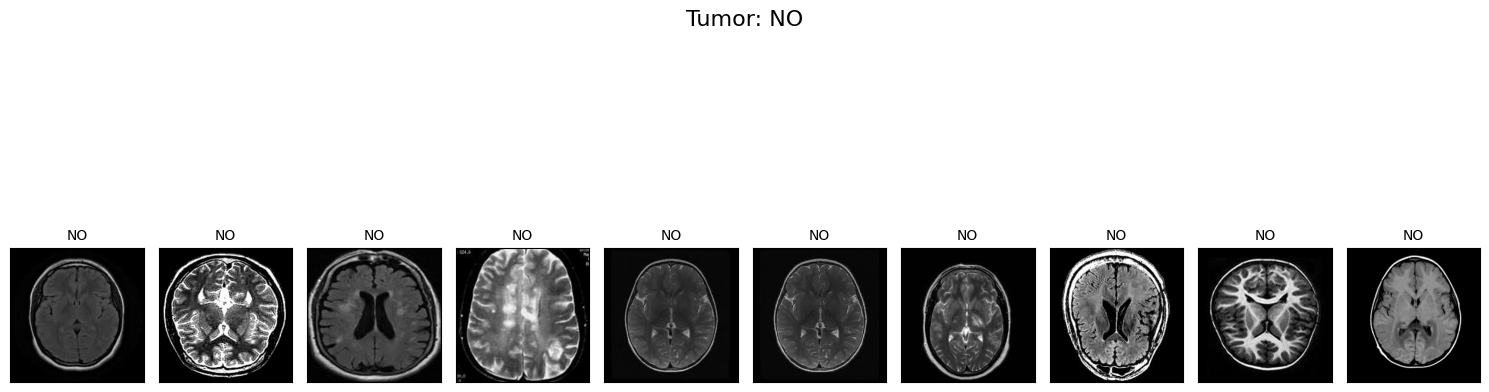

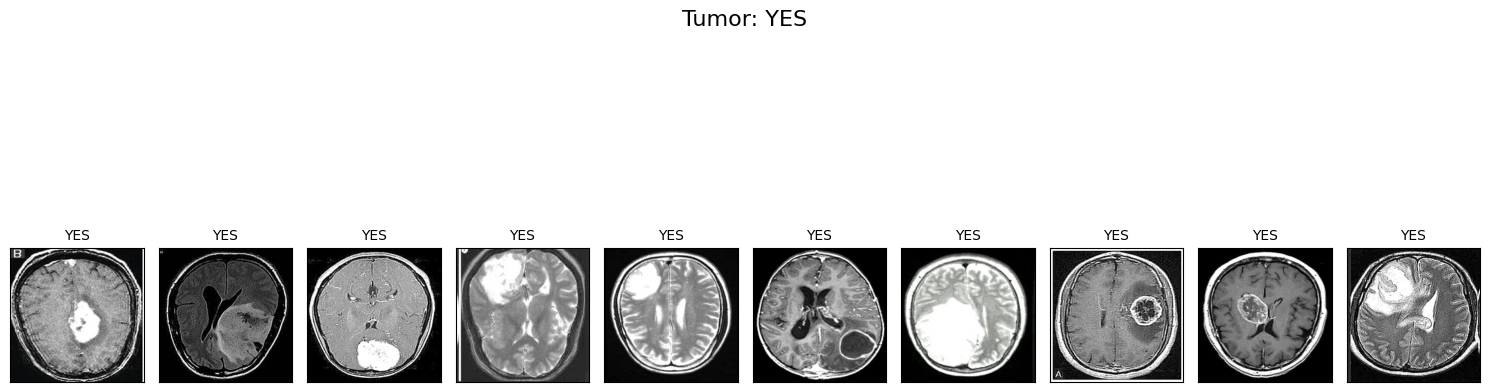

In [ ]:
# plot for images in each class (yes and no)
def plot_samples(X, y, labels_dict, n=10):
    for class_idx, class_label in enumerate(labels_dict):
        imgs = X[y == class_idx][:n]

        plt.figure(figsize=(15, 6))
        for i, img in enumerate(imgs):
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            plt.title(class_label, fontsize=10)

        plt.suptitle(f'Tumor: {class_label}', fontsize=16)
        plt.tight_layout()
        plt.show()

plot_samples(X_train, y_train, labels_train, n=10)


# CNN Model

## Data Augmentation

Visualization of image augmentation example

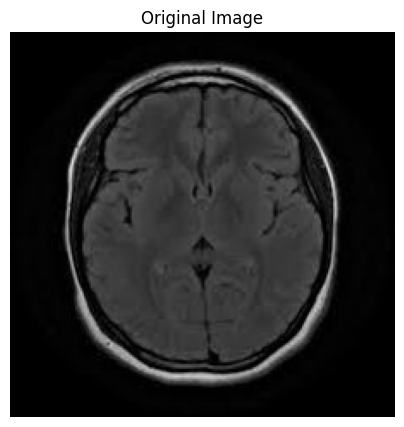

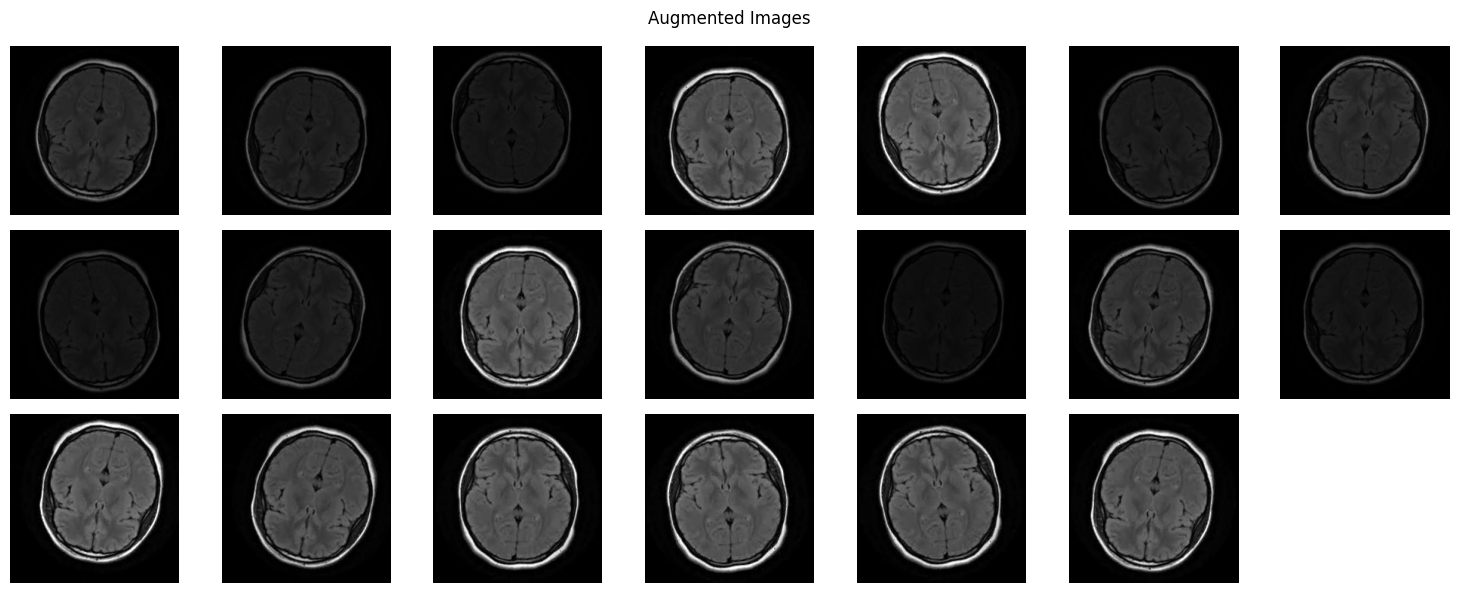

In [ ]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

# pick image
x = X_train[0]
x = x.reshape((1,) + x.shape)

# generate augmented images
augmented_images = [next(demo_datagen.flow(x, batch_size=1))[0] for _ in range(20)]

# plot of original image
plt.figure(figsize=(5, 5))
plt.imshow(X_train[0] / 255)
plt.title("Original Image")
plt.axis("off")
plt.show()

# plot of augmented image
plt.figure(figsize=(15, 6))
for i, img in enumerate(augmented_images[:21]):
    plt.subplot(3, 7, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Augmented Images")
plt.tight_layout()
plt.show()

Our data augmentation for training

In [ ]:
# for training
transform_train = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomRotation(degrees=20),
    RandomApply([ColorJitter(brightness=0.5, contrast=0.5)], p=0.5),
    RandomGrayscale(p=0.1),
    ToTensor()
])

# for validation and test
transform_val_test = Compose([
    Resize((224, 224)),
    ToTensor()
])

## Creating the Model

Adding complexities to the model

In [ ]:
batch_size = 32
train_dataset = datasets.ImageFolder('data_split/TRAIN/', transform=transform_train)
val_dataset = datasets.ImageFolder('data_split/VAL/', transform=transform_val_test)
test_dataset = datasets.ImageFolder('data_split/TEST/', transform=transform_val_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# model
class CNNModel(nn.Module):
    def __init__(self, input_channels):
        super(CNNModel, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # flatten size calculation
        self.flatten_size = 256 * (224 // 16) * (224 // 16)

        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout_fc = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = F.relu(self.conv4(x))
        x = self.pool4(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x


model = CNNModel(input_channels=3).to(device)

In [ ]:
# accuracy report
def evaluate_model_with_metrics(model, dataloader, size):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['No', 'Yes'])
    print(f"Classification Report:\n{report}")

    return accuracy

In [ ]:
# model
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


train_losses = []
val_accuracies = []
def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, scheduler):

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        val_acc = evaluate_model_with_metrics(model, val_loader, len(val_loader.dataset))
        val_accuracies.append(val_acc)

        scheduler.step(epoch_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {epoch_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    return train_losses, val_accuracies

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



In [ ]:
train_model(model, train_loader, val_loader, epochs=15, optimizer=optimizer, criterion=criterion, scheduler=scheduler)

Classification Report:
              precision    recall  f1-score   support

          No       0.74      0.82      0.78       300
         Yes       0.80      0.72      0.75       300

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.77      0.77      0.77       600

Epoch 1/15: Train Loss: 0.0166, Validation Accuracy: 0.7667
Classification Report:
              precision    recall  f1-score   support

          No       0.80      0.86      0.83       300
         Yes       0.85      0.78      0.81       300

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600

Epoch 2/15: Train Loss: 0.0129, Validation Accuracy: 0.8200
Classification Report:
              precision    recall  f1-score   support

          No       0.75      0.95      0.84       300
         Yes       0.93      0.69      0.79     

([0.016552150022415887,
  0.012881670480682736,
  0.011322138458490371,
  0.009573744648978824,
  0.009063045297350202,
  0.0067433994387586915,
  0.006287735152457442,
  0.004536754235270477,
  0.0034997432818636297,
  0.0037789008074573106,
  0.002920008778039898,
  0.003285046231356405,
  0.0028435690492568983,
  0.0027502867320020282,
  0.0024219295323737676],
 [0.7666666666666667,
  0.82,
  0.82,
  0.9,
  0.9,
  0.8983333333333333,
  0.94,
  0.9483333333333334,
  0.95,
  0.9466666666666667,
  0.9566666666666667,
  0.9466666666666667,
  0.9516666666666667,
  0.9333333333333333,
  0.9566666666666667])

In [ ]:
# model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]           2,432
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Conv2d-7          [-1, 256, 28, 28]         295,168
         MaxPool2d-8          [-1, 256, 14, 14]               0
            Linear-9                  [-1, 512]      25,690,624
          Dropout-10                  [-1, 512]               0
           Linear-11                    [-1, 2]           1,026
Total params: 26,081,602
Trainable params: 26,081,602
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

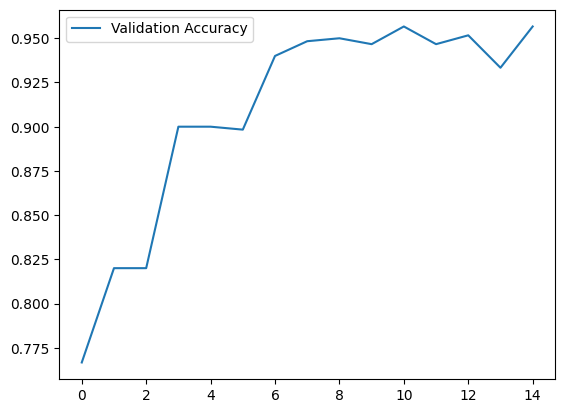

In [ ]:
# validation accuracy plot
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()

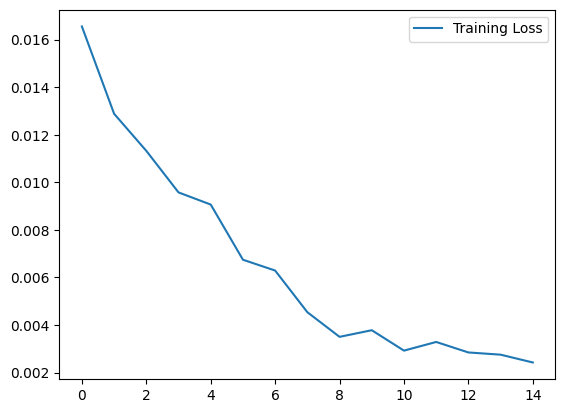

In [ ]:
# training loss plot
plt.plot(train_losses, label='Training Loss')
plt.legend()
plt.show()

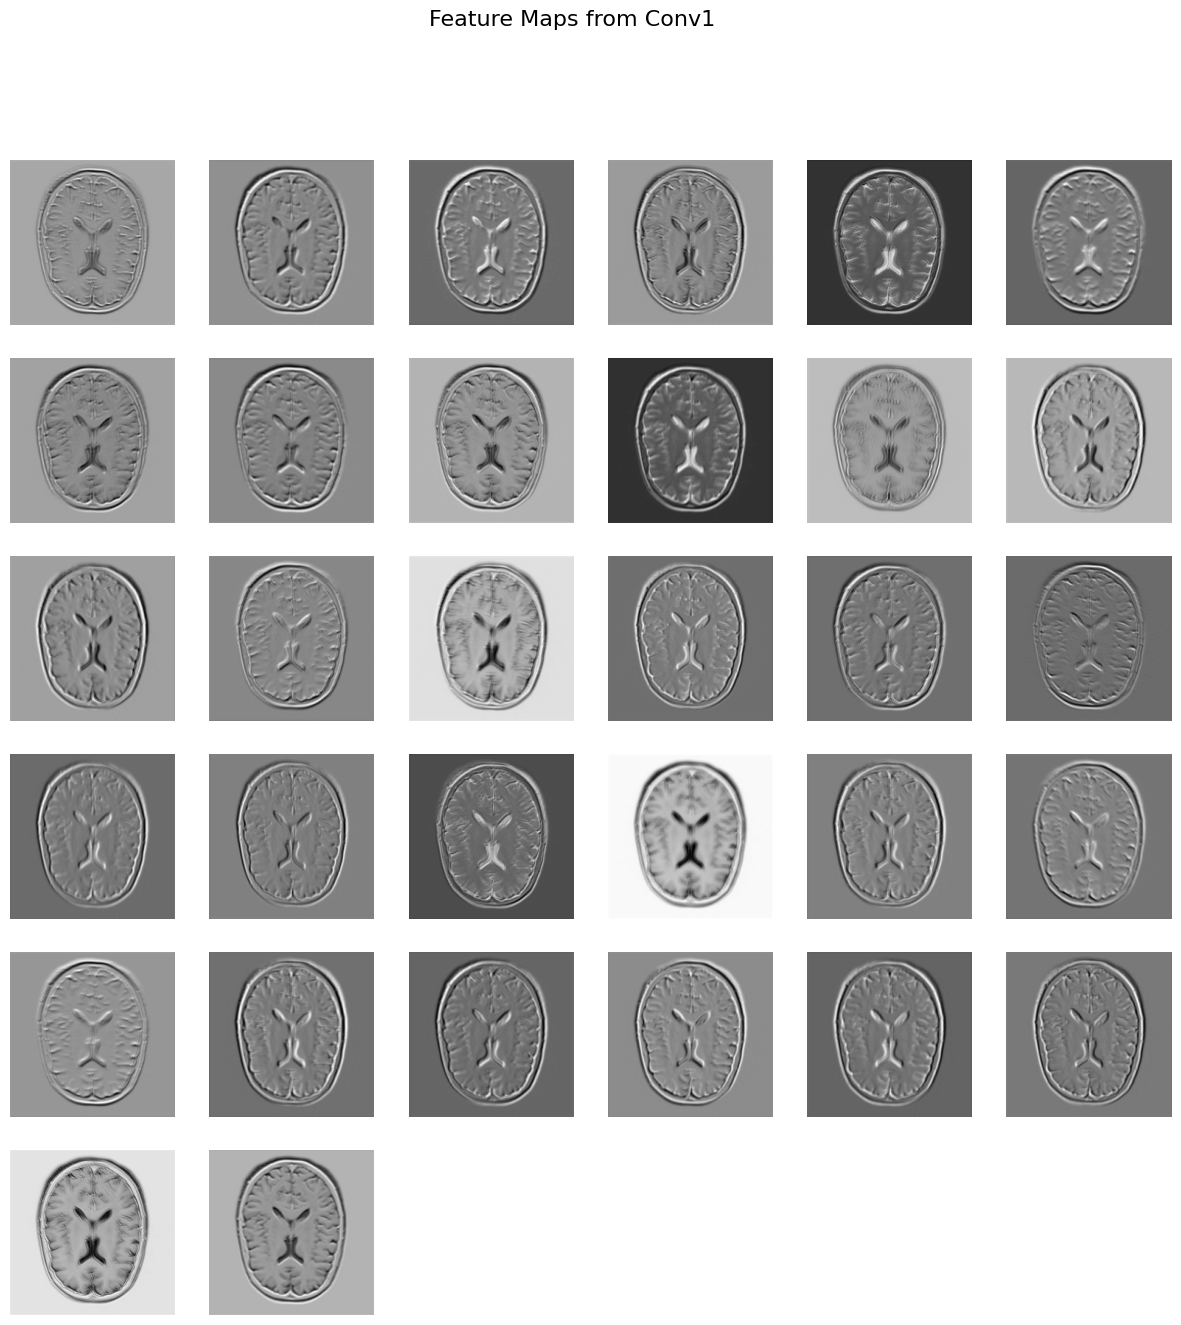

In [ ]:
# the feature maps generated by the first convolutional layer
def visualize_feature_maps(model, image):
    model.eval()
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        feature_maps = model.conv1(image)

    feature_maps = feature_maps.cpu().squeeze(0)

    num_features = feature_maps.shape[0]
    plt.figure(figsize=(15, 15))
    for i in range(num_features):
        plt.subplot(6, 6, i + 1)
        plt.imshow(feature_maps[i].detach().numpy(), cmap='gray')
        plt.axis("off")
    plt.suptitle("Feature Maps from Conv1", fontsize=16)
    plt.show()

# picking 1 image
test_image, _ = next(iter(test_loader))
visualize_feature_maps(model, test_image[0])


In [ ]:
# inputs, classes = next(iter(val_loader))
# out = torchvision.utils.make_grid(inputs)

# # Predict probabilities
# outputs = model_vgg(inputs.to(device))
# print(torch.exp(outputs))  # Compute the predicted probabilities

# # Compare with true classes
# print(classes)


Test Data Batch

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
test_dataset = datasets.ImageFolder('data_split/TEST/', transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
test_accuracy = evaluate_model_with_metrics(model, test_loader, len(test_loader.dataset))
print(f"Test Accuracy: {test_accuracy:.4f}")

Classification Report:
              precision    recall  f1-score   support

          No       0.99      1.00      1.00       150
         Yes       1.00      0.99      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

Test Accuracy: 0.9967


Here is a comparison between the best benchmarks from models we found on Kaggle and our model after hyperparameters tuning.

|                                                                           |  Validation Accuracy |   Test Accuracy |
|:----------------------------------------------------------------------------------------------------------------------------------------|-------:|------:|
| [EfficientNetB4](https://www.kaggle.com/code/ahmedhamada0/brain-tumor-detection-br35h#4.3.-Model-Performance)  |  0.998 | 0.997 |
| [VGG16](https://www.kaggle.com/code/gpiosenka/efficientnetb4-acc-score-99-67#Make-predictions-on-test-set-and-generate-Confusion-Matrix-and-Classification-Report)  |  0.93 | 0.92 |
| [CNN- Keras](https://www.kaggle.com/code/salikhussaini49/brain-tumor-prediction-97#Model-Summary)  |  0.968 | 0.971 |
| **Our Model**|  **0.957** | **0.997** |


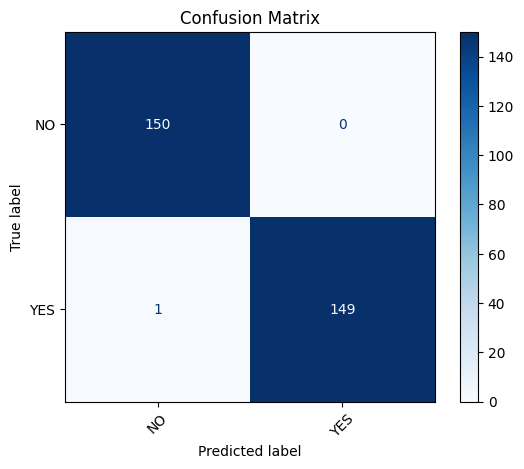

In [ ]:
# misclassifications confusion matrix
def plot_confusion_matrix(model, dataloader, labels):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels_batch in dataloader:
            inputs, labels_batch = inputs.to(device), labels_batch.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, test_loader, labels_test)

In [ ]:
# misclassifications predictions
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    for i in range(len(labels)):
        if preds[i] != labels[i]:
            print(f"True: {labels[i].item()}, Predicted: {preds[i].item()}")

True: 1, Predicted: 0


In [ ]:
# misclassifications MRI images
for i in range(len(labels)):
    if preds[i] != labels[i]:
        plt.imshow(inputs[i].cpu().permute(1, 2, 0))
        plt.title(f"True: {labels[i].item()}, Predicted: {preds[i].item()}")
        plt.show()